## 微调

### 为什么要用微调？

一般来说，源数据集通常较大，而目标数据集相对较小．对同一个模型来说，
可能该模型只适用于大数据集而不适用于小数据集，那么如果用收集的小数据集
去训练大的模型，会不会产生一系列的问题？如过拟合，如训练得到的模型精度不高？

**归纳来说，就是要解决：数据集与数据集，数据集与模型之间的矛盾．**

##### 相关名词

源数据集（如ImageNet有1000万张图片）, 目标数据集（自己要做分类的图片）

### 解决办法

迁移学习（将从源数据集中学习到的知识迁移到目标数据集上）
例如，虽然ImageNet数据集的图像大多跟椅子无关，
但在该数据集上训练的模型可以抽取较通用的图像特征，
从而能够帮助识别边缘、纹理、形状和物体组成等。
这些类似的特征对于识别椅子也可能同样有效。

### 具体实施

使用迁移学习中的微调来实现．

1. 在源数据集上训练出一个源模型
2. 创建目标模型．（除输出层不同以外，其他层及参数均与源模型保持一致．）
3. 为目标模型创建一个输出层（输出单元的个数取决于分类问题的类别数）并随机初始化．
4. 在目标数据集上开始训练．

### 好处
当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

### 例子：热狗识别

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append('../d2lzh/')
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
### １．准备数据集

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: ../Datasets/hotdog/train


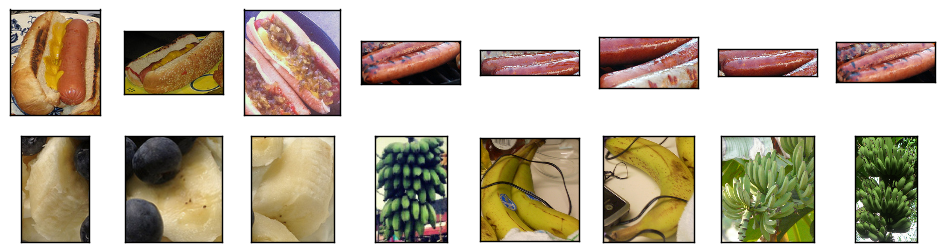

In [3]:
data_dir = '../Datasets/'
# os.listdir(os.path.join(data_dir, 'hotdog'))  # ['train', 'test']

# ＩmageFolder用于加载相关文件夹下的所有文件夹内的内容
train_images = ImageFolder(os.path.join(data_dir, 'hotdog/train')) # 前1000为hotdogs,后1000为not_hotdogs
test_images  = ImageFolder(os.path.join(data_dir, 'hotdog/test'))
print(train_images)

# 获取数据集的部分图片进行展示
hotdogs = [train_images[i][0] for i in range(8)]
not_hotdogs = [train_images[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs, 2, 8, scale=1.5);

In [4]:
###　对数据进行预处理（这些预处理与源数据集的预处理必须要保持一致）

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256), # 对输入数据先进行放大到256x256
        transforms.CenterCrop(size=224), # 做中心裁切
        transforms.ToTensor(),
        normalize,
    ])

In [6]:
### 模型（定义与初始化）

In [7]:
pretrained_net = models.resnet18(pretrained=True) # 下载模型(如果为True,则同时使用模型参数+模型，否则直接使用模型)
# 默认下载到'/home/tpg/.cache/torch/checkpoints/'下面，可使用　
'''
export TORCH_MODEL_ZOO="/local/pretrainedmodels
'''
# 来更改

# 打印模型
# print(pretrained_net)
# 打印模型的最后一层并更改
print(pretrained_net.fc)
pretrained_net.fc = nn.Linear(512, 2)  # 参数已经完成初始化，但其他层的参数依旧保持不变
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


In [8]:
# 更改模型的学习率（前面参数的学习率较低、最后一层参数的学习率较高）
# 先列出参数
output_params = list(map(id, pretrained_net.fc.parameters()))
# print(output_params)

# 过滤出其他参数
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())
# print(feature_params)

lr = 0.01
optimizer = optim.SGD([
        {'params': feature_params},
        {'params':pretrained_net.fc.parameters(), 'lr':lr * 10}],
        lr=lr, weight_decay=0.001,
    )

In [9]:
### 微调模型
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=10):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'),                                       transform=train_augs),
                           batch_size,
                           shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                          batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [10]:
### 训练

In [11]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 3.8808, train acc 0.675, test acc 0.894, time 46.9 sec
epoch 2, loss 0.1705, train acc 0.917, test acc 0.906, time 26.5 sec
epoch 3, loss 0.0782, train acc 0.936, test acc 0.931, time 30.3 sec
epoch 4, loss 0.0680, train acc 0.910, test acc 0.934, time 22.1 sec
epoch 5, loss 0.0322, train acc 0.943, test acc 0.926, time 26.0 sec
epoch 6, loss 0.0263, train acc 0.945, test acc 0.949, time 30.4 sec
epoch 7, loss 0.0184, train acc 0.954, test acc 0.931, time 28.5 sec
epoch 8, loss 0.0137, train acc 0.956, test acc 0.949, time 26.7 sec
epoch 9, loss 0.0111, train acc 0.962, test acc 0.895, time 25.5 sec
epoch 10, loss 0.0610, train acc 0.867, test acc 0.940, time 29.5 sec


In [8]:
### 对比（只采用原模型的结构，参数都是初始化）
scratch_net = models.resnet18(pretrained=False, num_classes=2)   # 只是一个结构，不带pretrain参数
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

training on  cuda
epoch 1, loss 2.6818, train acc 0.574, test acc 0.645, time 14.8 sec
epoch 2, loss 0.2582, train acc 0.792, test acc 0.766, time 14.6 sec
epoch 3, loss 0.1659, train acc 0.803, test acc 0.836, time 14.6 sec
epoch 4, loss 0.0998, train acc 0.830, test acc 0.789, time 14.6 sec
epoch 5, loss 0.0729, train acc 0.845, test acc 0.764, time 14.6 sec
epoch 6, loss 0.0672, train acc 0.816, test acc 0.848, time 14.6 sec
epoch 7, loss 0.0543, train acc 0.831, test acc 0.790, time 14.6 sec
epoch 8, loss 0.0459, train acc 0.842, test acc 0.801, time 14.7 sec
epoch 9, loss 0.0383, train acc 0.847, test acc 0.815, time 14.6 sec
epoch 10, loss 0.0360, train acc 0.849, test acc 0.815, time 14.7 sec
